In [1]:
import numpy as np
import pandas as pd
import datetime
from model2_cpx import Net_cpx_2D, Net_cpx
import time
import torch.optim as optim
from scipy import io
import argparse
import os                    
import torch
from losses import SSIMLoss2D,SSIMLoss2D_MC

from torch import nn
from torch.utils.data import Dataset, DataLoader
import h5py  
import matplotlib.pyplot as plt
import h5py  
import matplotlib
from PIL import Image
import math
from sklearn.metrics import confusion_matrix
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" #USE gpu 1, gp0 cannot be used for some reason
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda


In [3]:
epoch_num = 4
num_workers = 0

current_data = '/home/alphabet/DL-PF/codes/'
# current_data_file = current_data + 'Save/'

current_data_file = current_data + 'generated_dataset/'

os.makedirs(current_data+'/model_save3'+'/', exist_ok=True)
model_save_path = current_data + '/model_save3'+'/'

class prepareData(Dataset):
    def __init__(self, train_or_test):
        self.files = os.listdir(current_data_file+train_or_test)
        self.train_or_test= train_or_test

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        c=current_data_file+self.train_or_test+'/'+self.files[idx]
        
        data = torch.load(current_data_file+self.train_or_test+'/'+self.files[idx])
        return data['k-space'],  data['label']
trainset = prepareData('train')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=num_workers) #Change batch size to 16

validationset = prepareData('valid')
validationloader = torch.utils.data.DataLoader(validationset, batch_size=1,shuffle=True, num_workers=num_workers)

testset = prepareData('test')
testloader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=False, num_workers=num_workers)

model = Net_cpx().to(device)
# print(model)


In [4]:
criterion1 = nn.L1Loss()


# lr = 0.0002
# nx = 218
# ny = 170


# lr = 0.0002
lr = 0.0002
nx = 256
ny = 256
nc = 2

weight_decay = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# ssim = SSIMLoss2D()
ssim = SSIMLoss2D_MC(in_chan=2)

In [5]:
loss_train_list = []
loss_validation_list = []

for epoch in range(epoch_num):   #set to 0 for no running the training
    model.train()

    loss_batch = []
    time_start=time.time()    
    for i, data in enumerate(trainloader, 0):
        if i >= 36:
            break  # Limiting to 40 batches per epoch
        inputs = data[0].reshape(-1,nc,ny,nx).to(device) ##single slice
        label = data[1].reshape(-1,2,ny,nx).to(device) 
        
        labels = inputs + label    

        outs = model(inputs)

        
        loss = criterion1(outs, labels) 
        
        if loss.item() < 0.7:
            loss = ssim(outs, labels,1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_batch.append(loss.item())  
        if (i)%3==0:
            print('epoch:%d - %d, loss:%.10f'%(epoch,i,loss.item()))
        # break
        # h=0
    loss_train_list.append(round(sum(loss_batch) / len(loss_batch),10))
    print(loss_train_list)
    time_end=time.time()
    print('time cost for training',time_end-time_start,'s')

    model.eval()     # evaluation
    loss_batch = []
    print('\n validation...')
    time_start=time.time()
    for i, data in enumerate(validationloader, 0):
        inputs = data[0].reshape(-1,nc,ny,nx).to(device)
        label = data[1].reshape(-1,2,ny,nx).to(device) 
        if nc ==6:
            labels= label
            labels[:,0,:,:]= label[:,0,:,:] +inputs[:,0,:,:]
            labels[:,1,:,:]= label[:,1,:,:] +inputs[:,3,:,:]
        else:
            labels = inputs + label

        with torch.no_grad():
            outs = model(inputs)

        
        loss = criterion1(outs, labels)
        if loss.item() < 0.7:
            loss = ssim(outs, labels,1)   
            
        loss_batch.append(loss.item())
        
    time_end=time.time()
    print('time cost for validation',time_end-time_start,'s')
    loss_validation_list.append(round(sum(loss_batch) / len(loss_batch),10))
    print(loss_validation_list)

    torch.save(model, os.path.join(model_save_path, 'epoch-%d-%.10f.pth' % (epoch, loss.item())))

    

print('Finished Training')


epoch:0 - 0, loss:0.8685977459
epoch:0 - 3, loss:0.9901982546
epoch:0 - 6, loss:0.9305188656
epoch:0 - 9, loss:0.8277820349
epoch:0 - 12, loss:0.7438644171
epoch:0 - 15, loss:0.6633298397
epoch:0 - 18, loss:0.5776165724
epoch:0 - 21, loss:0.4974728227
epoch:0 - 24, loss:0.4456270933
epoch:0 - 27, loss:0.6665372849
epoch:0 - 30, loss:0.4761642218
epoch:0 - 33, loss:0.4983466864
[0.6709327863]
time cost for training 669.9445643424988 s

 validation...
time cost for validation 138.39982342720032 s
[0.3292442465]
epoch:1 - 0, loss:0.3306192756
epoch:1 - 3, loss:0.2724912763
epoch:1 - 6, loss:0.2744787335
epoch:1 - 9, loss:0.2740988731
epoch:1 - 12, loss:0.3348358274
epoch:1 - 15, loss:0.2958130240
epoch:1 - 18, loss:0.2223560214
epoch:1 - 21, loss:0.1920806170
epoch:1 - 24, loss:0.1745096445
epoch:1 - 27, loss:0.1869173050
epoch:1 - 30, loss:0.1417645216
epoch:1 - 33, loss:0.1397917867
[0.6709327863, 0.2344986714]
time cost for training 668.0610938072205 s

 validation...
time cost for val

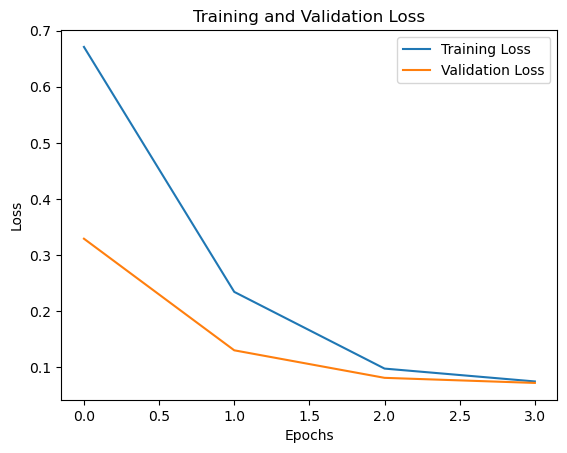

In [6]:
# # Plotting the loss curves
# plt.figure(figsize=(10, 5))
# plt.plot(loss_train_list, label='Training Loss')
# plt.plot(loss_val_list, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Curves')
# plt.legend()
# plt.grid(True)
# plt.show()

# print('Finished Training')

# Plotting the loss
plt.plot(loss_train_list, label='Training Loss')
plt.plot(loss_validation_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [7]:
model_path = '/home/alphabet/DL-PF/codes/model_save3/epoch-3-0.0744823813.pth'  # Provide the path to your saved model
trained_model = torch.load(model_path)

In [8]:
trained_model.eval()
try:
    input_data, label_data = next(iter(testloader))
except StopIteration:
    print("No more data in the testloader.")

In [9]:
with torch.no_grad():
    input_data = input_data.to(device)
    output = trained_model(input_data)

In [10]:
print("Output size:", output.size())

Output size: torch.Size([1, 2, 256, 256])


In [11]:
input_array = input_data.squeeze().cpu().numpy()
label_array = label_data.squeeze().cpu().numpy()
output_array = output.squeeze().cpu().numpy()

# Display the shape of the arrays
print("Input array shape:", input_array.shape)
print("Label array shape:", label_array.shape)
print("Output array shape:", output_array.shape)

Input array shape: (2, 256, 256)
Label array shape: (2, 256, 256)
Output array shape: (2, 256, 256)


In [12]:
input_image = input_array[0,:,:] + 1j* input_array[1,:,:]

label_image = label_array[0,:,:] + 1j* label_array[1,:,:]

output_image = output_array[0,:,:] + 1j* output_array[1,:,:]


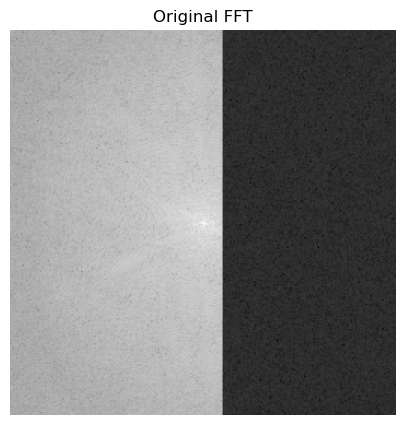

In [13]:

fft_image = np.fft.fft2(input_image)

fft_shifted = np.fft.fftshift(fft_image)

plt.figure(figsize=(10, 5))

plt.imshow(np.log(np.abs(fft_image)), cmap='gray')
plt.title('Original FFT')
plt.axis('off')
plt.show()

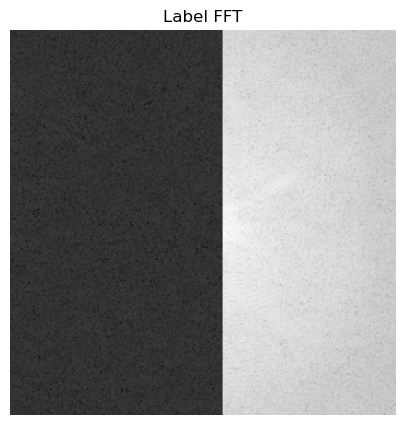

In [14]:
fft_image = np.fft.fft2(label_image)

fft_shifted = np.fft.fftshift(fft_image)

plt.figure(figsize=(10, 5))

plt.imshow(np.log(np.abs(fft_image)), cmap='gray')
plt.title('Label FFT')
plt.axis('off')
plt.show()

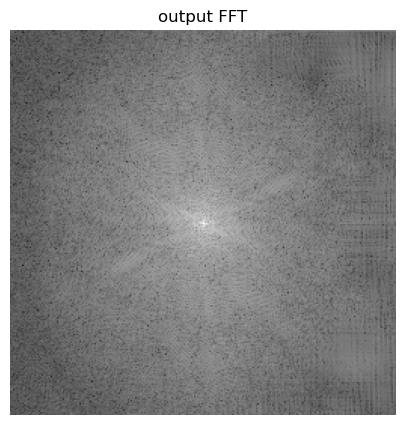

In [15]:
fft_image = np.fft.fft2(output_image)

fft_shifted = np.fft.fftshift(fft_image)

plt.figure(figsize=(10, 5))

plt.imshow(np.log(np.abs(fft_image)), cmap='gray')
plt.title('output FFT')
plt.axis('off')

plt.show()

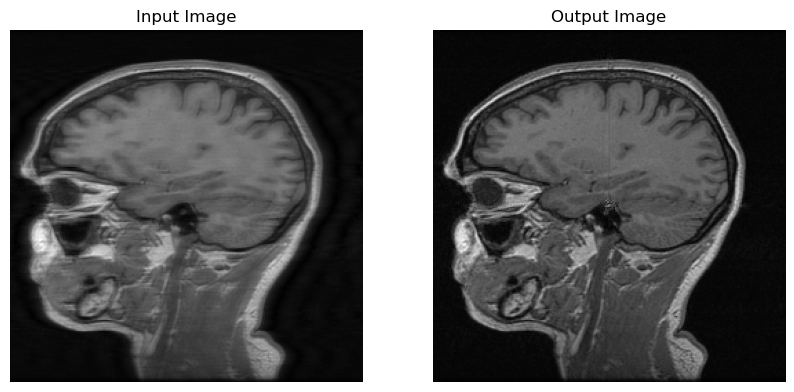

In [16]:
# Take absolute values of the complex images
abs_input_image = np.abs(np.fft.fftshift(input_image))
abs_label_image = np.abs(np.fft.fftshift(label_image))
abs_output_image = np.abs(np.fft.fftshift(output_image))

# Create a figure and set its size
plt.figure(figsize=(10, 5))

# Plot input_image
plt.subplot(1, 2, 1)
plt.imshow(abs_input_image, cmap='gray')
plt.title('Input Image')
plt.axis('off')

# # Plot label_image
# plt.subplot(1, 3, 2)
# plt.imshow(abs_label_image, cmap='gray')
# plt.title('Label Image')
# plt.axis('off')

# Plot output_image
plt.subplot(1, 2, 2)
plt.imshow(abs_output_image, cmap='gray')
plt.title('Output Image')
plt.axis('off')

# Show the plot
plt.show()

In [ ]:
# import cv2
# import numpy as np
# from matplotlib import pyplot as plt

# # Read the image
# image = cv2.imread('input_image.jpg', cv2.IMREAD_GRAYSCALE)

# # Perform Fourier transform
# f_transform = np.fft.fft2(image)
# f_transform_shifted = np.fft.fftshift(f_transform)
# magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted))

# # Inverse Fourier transform
# f_transform_inverse_shifted = np.fft.ifftshift(f_transform_shifted)
# image_back = np.fft.ifft2(f_transform_inverse_shifted)
# image_back = np.abs(image_back)

# # Plot original and processed images
# plt.subplot(121), plt.imshow(image, cmap='gray')
# plt.title('Input Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(122), plt.imshow(image_back, cmap='gray')
# plt.title('Inverse Fourier Transform'), plt.xticks([]), plt.yticks([])
# plt.show()